# A Step-By-Step Tutorial on Speech Processing, Analysis, and Classification <img align="center" width="15%" src='Images/title.png' alt="title" />
## This tutorial is divided into 2 parts:

- Part 1: Demonstrates how to convert signal to frequency domain, compute spectrogram, mel-spectrogram, and MFCC step by step.
- Part 2: Introduction to MultiResolution Analysis and Wavelet Transform. Classification using Wavelet Transform

<hr>

## Firstly, import libraries that we will use in this tutorial

In [18]:

# Import libraries
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pandas as pd, pickle
import random
from random import seed, random, randint, sample

import tensorflow.keras as keras
from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, GlobalMaxPool1D, Activation, MaxPool1D, Conv1D, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import librosa 
import librosa.display
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
from librosa.filters import mel
import pywt
import scipy
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# Part 1: Converting time signal to frequency domain and extract spectrogram, mel-sepctrogram, and MFCC(Mel-filter cepstrum coefficients). 

## Step 1: Reading a sample audio file. 

- We will read an audio file using librosa library
- Display its waveform in time domain

Length of signal:  6571
Sampling rate:  22050


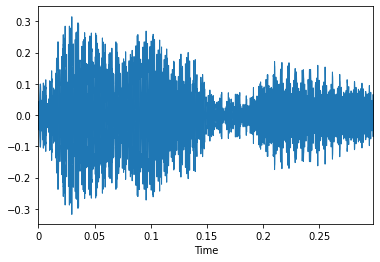

In [19]:
# Read a sample file
filename = os.getcwd() + "/recordings/0_george_0.wav"

# Read an audio file using librosa
y, sr = librosa.load(filename)

# Print length and sampling rate of signal
print("Length of signal: ", len(y))
print("Sampling rate: ", sr)

# Display the waveform
librosa.display.waveplot(y, sr=sr)


## Step 2: Convert the signal from time domain to frequency domain. 

- We will find fourier transform of the time signal
- Display the spectrogram and power spectrogram (decibels) of the signal


The Fourier Transform is a mathematical technique that transforms a function of time, x(t), to a function of frequency, X(ω). It decomposes a periodic waveforms into sinusoids. When we compute Fourier transform on a sampled data, we use a discrete version of Fourier transform called Discrete Fourier Transform.

If we perform DFT, we will get overall frequency components of a signal. But, we won't know how frequency changes with time. So, we use Short-Time Fourier Transform (STFT) instead. In STFT, we slide a window along the time signal and perform DFT on each window. The sampling rate of signal is 22.05 KHz. It is a standard sampling rate for sampling audio files. According to Nyquist, this will give us a bandwidth of 11.025 kHz.

In [ ]:
##################################
#### Display spectrogram and power-spectrogram ###
##################################

# In librosa, the default value of number of fft is 2048 which corresponds to a duration of 93ms for sampling rate of 22.05 KHz. It is more suitable for music. 
# For speech, 512 ffts can be used. It corresponds to a duration of 23 ms for a sampling rate of 22.05 KHz.
S = np.abs(librosa.stft(y, n_fft=512, win_length= 512, hop_length= 128))

# Display spectrogram using librosa
img = librosa.display.specshow(S, y_axis='hz', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(img)
plt.show()

# Display power spectrogram by converting amplitude to decibels
img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='log', x_axis='time')
plt.title('Power Spectrogram')
plt.colorbar(img)
plt.show()

## Step 3: Convert spectrogram to mel-spectrogram using mel scale

- Humans can hear roughly between 20Hz-20KHz.
- But the perception of sound for humans is non-linear.
- We can better distinguish the difference of frequencies between 200 and 300 Hz than difference between 15 KHz and 15.1 KHz.
- The Mel scale is a logarithmic scale of a signal's frequencies. 

This is the formula to convert frequency to mel-scale. <img align="center" alt="mel_formula" width=20% src="./Images/mel_formula.png" />

<br />

Below is an illustration to explain how the mel filters work. <br />
<br />
<img align="center" alt="mel_filter" width=50% src="./Images/mel_filter.png" />

<br />

Firstly, we will visualize mel scale filters and then convert our spectrogram to mel-spectrogram.

In [ ]:
# Let's create two quick utility functions to convert frequency to mel-scale and vice-versa.

# Convert frequency to mel-scale
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

# Convert mel-scale to frequency
def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0) 

(10, 257)


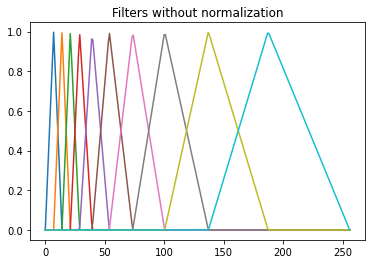

(10, 257)


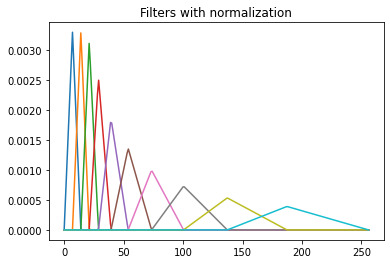

In [ ]:
##################################
#### Display mel-filters #########
##################################

# We have set number of mel-filters to 10 for convenience.

# Filters without normalization
melf_filter = librosa.filters.mel(22050, n_fft=512, n_mels= 10, norm= None)

# The shape of filter is (10 x 257). Number of ffts were 512. Half were discarded because of aliasing (Nyquist theorem). The shape of mel-filter is (n_mel_filter x (1+nfft/2)).
print(melf_filter.shape)

# Plot filters
for i in range(melf_filter.shape[0]) :
    plt.plot(melf_filter[i])

plt.title("Filters without normalization")
plt.show()


# Filters with normalization
melf_filter = librosa.filters.mel(22050, n_fft=512, n_mels= 10, norm= 'slaney')
print(melf_filter.shape)

for i in range(melf_filter.shape[0]) :
    plt.plot(melf_filter[i])

plt.title("Filters with normalization")
plt.show()

# NOTE: Each row in mel-filter correspond to a mel filter and each column corresponds to weight for each frequency for mel-filter bank.
# Now, notice that all the filters have a peak value of 1. This becomes a problem as we increase the width of a filter. It is because an increase in width will lead to higher noise. 
# So, we normalize the filters by their area. It's called area normalization.



Mel filter shape  (128, 257)
Spectrogram shape  (257, 52)
Mel spectrogram shape:  (128, 52)


/Users/adityadutt/Downloads/SpeechTutorial/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/adityadutt/Downloads/SpeechTutorial/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


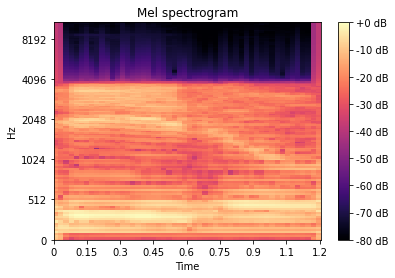

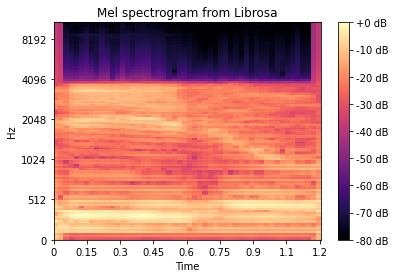

In [ ]:
##################################
#### Display a mel-spectrogram ###
##################################

# Now, earlier we set the number of mel-filters to 10 for convenience. Usually, 128 or more melfilters are used for speech to acheive good results. So, we will use use 128 filters.

melf_filter = librosa.filters.mel(22050, n_fft=512, n_mels= 128, norm= 'slaney')

# Print shapes of spectrograms
print("Mel filter shape ", melf_filter.shape)
print("Spectrogram shape ", S.shape)

# COmpute dot product of mel filter and spectrogram
melS = np.dot(melf_filter, S)
print("Mel spectrogram shape: ", melS.shape)

# Compute power spectrogram
melS_dB_computed = librosa.power_to_db(melS, ref=np.max)

# Display power spectrogram
img = librosa.display.specshow(melS_dB_computed, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(img, format='%+2.0f dB')
plt.title("Mel spectrogram")
plt.show()


# Display power spectrogram using librosa
melS_librosa = librosa.feature.melspectrogram(S=S, n_fft=512, win_length= 512, hop_length= 128, n_mels=128)
img = librosa.display.specshow(librosa.power_to_db(melS_librosa, ref=np.max), x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(img, format='%+2.0f dB')
plt.title("Mel spectrogram from Librosa")
plt.show()


## Step 4: Generate MFCCs 

The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficients using Discrete Cosine Transform (DCT). 
So, now we have to take DCT of mel-spectrogram to get MFCCs.

You can think of DCT as a compression step. When we get melspectrogram, we have a spectrum that is similar to how human hearing works. When we apply DCT, we capture fine aspects of this spectrum and small the difference in frequencies. Some aspects of this spectrum are more important than others. DCT can capture this variations and details and keep lower coefficients while discarding higher coefficients. 

DCT also decorrelates the filterbanks coefficients. This is known as whitening. 

Also the resulting DCT coefficients are real-valued, which makes subsequent processing and storage easier. There are many versions of DCT but DCT-2 is commonly used.

Note: Discrete Cosine Transform (DCT) is a linear transformation, and it discards some information in speech signals which is highly non-linear.

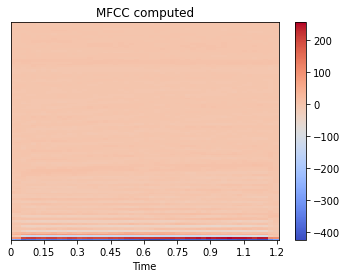

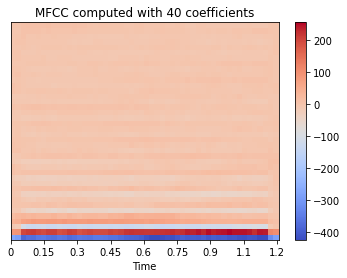

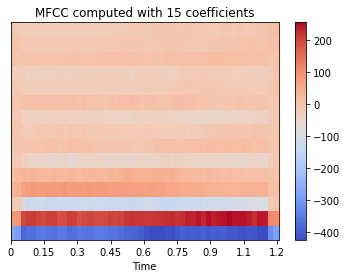

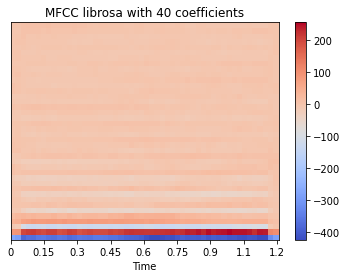

In [ ]:
from scipy.fftpack import fft, dct

# Compute DCT of power transform
mfcc = dct(melS_dB_computed, axis=0, type=2, norm='ortho')


# Display MFCCs
img = librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar(img)
plt.title('MFCC computed')
plt.show()

# Take the top 40 coefficients and display MFCCs
mfcc40 = mfcc[:40, :]
img = librosa.display.specshow(mfcc40, x_axis='time')
plt.colorbar(img)
plt.title('MFCC computed with 40 coefficients')
plt.show()

# Take the top 15 coefficients and display MFCCs
mfcc15 = mfcc[:15, :]
img = librosa.display.specshow(mfcc15, x_axis='time')
plt.colorbar(img)
plt.title('MFCC computed with 15 coefficients')
plt.show()

# NOTE: You can select the number of coefficients to keep based on your own audio sample and task.

# Let's compare the result with librosa MFCC function.
mfcc_librosa = librosa.feature.mfcc(S=melS_dB_computed, n_fft=512, win_length= 512, hop_length= 128, n_mfcc=40)
img = librosa.display.specshow(mfcc_librosa, x_axis='time')
plt.colorbar(img)
plt.title('MFCC librosa with 40 coefficients')
plt.show()

# We can assert that our computed MFCCs are close to the Librosa's MFCCs.
assert np.allclose(mfcc40, mfcc_librosa) == True

# Part 2: MultiResolution Analysis and Wavelet Transform
### ```Multiresolution analysis (MRA) refers to breaking up a signal into components, which produce the original signal exactly when added back together```. The term multiresolution analysis is often associated with wavelets, but there are some other non-wavelet techniques as well. In wavelet transform, we analyze the signal at different scales and at different timesteps. The scaled and shifted wavelets form a multiresolution analysis.

## <b> What is a Wavelet? </b>
### A Wavelet is a wave-like oscillation that is localized in time. Wavelets have 2 fundamental properties: scale and location. Scale defines how “stretched” or “squished” a wavelet is. Location is a position in time. You can see in the image below an example of squished and stretched wavelet.

<img align="left" alt="squished" width=20% src="./Images/squished.png" />
<img align="center" alt="stretched" width=20% src="./Images/stretched.png" />

<br />

### Here is the formula of wavelet transform: <img align="center" alt="formula" width=18% src="./Images/formula.png" />

<br />
<br />


## <b> Need for Wavelets </b>

### Fourier Transform has a big drawback. It's picking the right window size. According to Heisenberg's uncertainty principle:
- A narrow window will localize signal in time but there will be significant uncertainty in frequency.
- If the window is wide enough, then the time uncertainty increases.

### Thee is this tradeoff between time and frequency resolution. 
### One way to avoid this problem is Multiresolution Analysis (MRA). An example of MRA is Wavelet Transform.
### In MRA, a signal is analyzed at different resolution levels.
### Wavelet transform can change the "scale" paramater to find different frequencies in signal along with their location. So, now we know which frequencies exist in the time singal and where they exist. Smaller scale means a wavelet is squished. So, it can capture higher frequencies. On the other hand, a larger scale can capture lower frequencies. 
### This is the advantage that wavelet transform has over FFT. It can capture spectral and temporal information simultaneously.

<br />
<br />

## <b> Morlet Wavelet </b>

### Morlet wavelet is closely related to human perception of hearing and vision. We will use this wavelet for this tutorial. 
### It is composed of complex exponential multiplied with gaussian window. The formula of Morlet Wavelet is: <img align="center" alt="morlet_formula" width=20% src="./Images/morlet.png" />

### Here is what a morlet wavelet looks like: <img align="center" alt="morlet_image" width=20% src="./Images/morlet_image.png" />

<br />
<br />

<hr>

### Now, we will compute wavelet transform of a sample audio file and display its scalogram. 
### A scalogram is the absolute value of the continuous wavelet transform (CWT) of a signal. We can plot it as a function of time and frequency/scales.

These are the scales that we are using:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
These are the frequencies that re associated with the scales:  [6500.         3250.         2166.66666667 1625.         1300.
 1083.33333333  928.57142857  812.5         722.22222222  650.
  590.90909091  541.66666667  500.          464.28571429  433.33333333
  406.25        382.35294118  361.11111111  342.10526316  325.
  309.52380952  295.45454545  282.60869565  270.83333333  260.
  250.          240.74074074  232.14285714  224.13793103  216.66666667
  209.67741935  203.125       196.96969697  191.17647059  185.71428571
  180.55555556  175.67567568  171.05263158  166.66666667  162.5
  158.53658537  154.76190476  151.1627907   147.72727273  144.44444444
  141.30434783  138.29787234  135.41666667  132.65306122  130.
  127.45098039  125.          122.641509

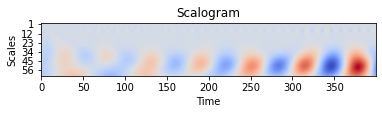

In [ ]:
# Read a sample file
filename = os.getcwd() + "/recordings/0_george_0.wav"

# Read an audio file using librosa
y, sr = librosa.load(filename)

wavelet = 'morl' # wavelet type: morlet
sr = 8000 # sampling frequency: 8KHz
widths = np.arange(1, 64) # scales for morlet wavelet 
print("These are the scales that we are using: ", widths)
dt = 1/sr # timestep difference

frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
print("These are the frequencies that re associated with the scales: ", frequencies)

# Compute continuous wavelet transform of the audio numpy array
wavelet_coeffs, freqs = pywt.cwt(y, widths, wavelet = wavelet, sampling_period=dt)
print("Shape of wavelet transform: ", wavelet_coeffs.shape)

# Display the scalogram. We will display a small part of scalogram because the length of scalogram is too big.
plt.imshow(wavelet_coeffs[:,:400], cmap='coolwarm')
plt.xlabel("Time")
plt.ylabel("Scales")
plt.yticks(widths[0::11])
plt.title("Scalogram")
plt.show()

## <b> Problem Statement </b>
### In this tutorial, we will use the spoken digit dataset. We will extrcat wavelet transform of each audio sample. Then, we will use these features to classify different speakers.

<br />

## <b> Dataset: [Free Spoken Digit Dataset(FSDD)](https://github.com/Jakobovski/free-spoken-digit-dataset)</b>

### A simple audio/speech open dataset consisting of recordings of spoken digits in wav files at 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

### It contains:
- 6 speakers
- 3,000 recordings (50 of each digit per speaker)
- English pronunciations

<br />

## <b> Implementation </b>


## Step 1: Read the data, split into train/test and store in a .npz file 

In [ ]:
'''
# The data in the current directory inside the doler "recordings".
dir = os.getcwd() + "/recordings/"

# Read audio files from the directory. For this tutorial, we will only classify 3 speakers: george, jackson, and lucas.
# Audio files have this format : {digit}_{speaker}_{speaker_filenumber}.wav

audio = [] # List to store audio np arrays
y = [] # List to store the target class labels

for root, dirs, files in os.walk(dir, topdown=False):    
    for name in files:

        if name.find(".wav") != -1 : # Check if the file has a .wav extension            
            if name.find("george") != -1 or name.find("jackson") != -1 or name.find("lucas") != -1 : # Check if the speaker is george, jackson, and lucas.
                fullname = os.path.join(root, name)
                audio.append(fullname) # Append the np array to the list.
                if name.find("george") != -1 :
                    y.append(0)
                elif name.find("jackson") != -1 :
                    y.append(1)
                else :
                    y.append(2)

# Write the audio data in a npz file so that we don't have to read the audio files again. We can load the data from npz file. Also, the npz format is very space efficient.
audio_train, audio_test, y_train, y_test = train_test_split(audio, y, test_size=0.3)
np.savez_compressed(os.getcwd()+"/training_raw_audio", a=audio_train, b=y_train)
np.savez_compressed(os.getcwd()+"/testing_raw_audio", a=audio_test, b=y_train)

print("Finished writing to npz file...")

# Print the class distribution
print("Training Data class distribution: ", np.unique(y_train, return_counts=True))
print("Testing Data class distribution: ", np.unique(y_test, return_counts=True))
'''


'\n# The data in the current directory inside the doler "recordings".\ndir = os.getcwd() + "/recordings/"\n\n# Read audio files from the directory. For this tutorial, we will only classify 3 speakers: george, jackson, and lucas.\n# Audio files have this format : {digit}_{speaker}_{speaker_filenumber}.wav\n\naudio = [] # List to store audio np arrays\ny = [] # List to store the target class labels\n\nfor root, dirs, files in os.walk(dir, topdown=False):    \n    for name in files:\n\n        if name.find(".wav") != -1 : # Check if the file has a .wav extension            \n            if name.find("george") != -1 or name.find("jackson") != -1 or name.find("lucas") != -1 : # Check if the speaker is george, jackson, and lucas.\n                fullname = os.path.join(root, name)\n                audio.append(fullname) # Append the np array to the list.\n                if name.find("george") != -1 :\n                    y.append(0)\n                elif name.find("jackson") != -1 :\n     

In [ ]:
# Load the data from the .npz file
train_data = np.load(os.getcwd()+"/training_raw_audio.npz", allow_pickle=True)
audio_train = train_data['a']
y_train = train_data['b']

test_data = np.load(os.getcwd()+"/testing_raw_audio.npz", allow_pickle=True)
audio_test = test_data['a']
y_test = test_data['b']


## Step 2: Write a function to compute continuous wavelet transform features of each audio sample
### Human Voice Frequency Range:
- The human ear can hear between 20 and 20,000 Hz (20 kHz) but it is most sensitive to everything that happens between 250 and 5,000 Hz.
- The voiced speech of a typical adult male will have a fundamental frequency from 85 to 180 Hz, and that of a typical adult female from 165 to 255 Hz.
- For a child’s voice, average fundamental frequency is 300Hz.
- Consonants take up space between 2kHz and 5kHz.
- Vowel Sounds are prominent between 500Hz and 2kHz.

### We will keep frequencies only between 80 Hz and 5KHz.
### We will split each audio into frames of length 800.

In [ ]:
def compute_wavelet_features(X) :

    # Define a few parameters
    wavelet = 'morl' # wavelet type: morlet
    sr = 8000 # sampling frequency: 8KHz
    widths = np.arange(1, 256) # scales for morlet wavelet 
    dt = 1/sr # timestep difference

    frequencies = pywt.scale2frequency(wavelet, widths) / dt # Get frequencies corresponding to scales
    
    # Create a filter to select frequencies between 80Hz and 5KHz
    upper = ([x for x in range(len(widths)) if frequencies[x] > 1000])[-1]
    lower = ([x for x in range(len(widths)) if frequencies[x] < 80])[0]
    widths = widths[upper:lower] # Select scales in this frequency range

    # Compute continuous wavelet transform of the audio numpy array
    wavelet_coeffs, freqs = pywt.cwt(X, widths, wavelet = wavelet, sampling_period=dt)
    # print(wavelet_coeffs.shape)
    # sys.exit(1)

    # Split the coefficients into frames of length 800
    start = 0
    end = wavelet_coeffs.shape[1]
    frames = []
    frame_size = 400
    count = 0

    while start+frame_size <= end-1 :

        f = wavelet_coeffs[:,start:start+frame_size]        

        # Total samples in a frame will not be a multiple of 800 everytime. If the last frame length is less than 800, we can skip it.
        assert f.shape[1] == frame_size # assert frame lengths are equal to the frame_size parameter

        frames.append(f)
        start += frame_size


    # Convert frames to numpy array
    frames = np.array(frames)
    frames = frames.reshape((len(frames), wavelet_coeffs.shape[0], frame_size))

    return frames

## Step 3: Compute continuous wavelet transform of training and testing data using the function in Step 3

In [ ]:
'''
### Compute Training data features. We have each sample into frames of length 400

indices = []
WaveletFeatTrain = [] # Store wavelet features
WaveletYTrain = [] # Store class labels corresponding to wavelet features from an audio sample
uniq_id = []
count = 0

for i in range(3) :
    
    ind, = np.where(y_train == i)
    seed(i)
    ind = ind.tolist()
    ind = sample(ind, 100)
    audio_samples = audio_train[ind]
    num_rand_samp = 100

    for j in tqdm(range(len(audio_samples))) :

        # print("i ", i, " j ", j, "/", len(audio_samples))
        curr_sample = audio_samples[j]
        seq, _ = librosa.load(curr_sample) 
        F = compute_wavelet_features(seq)
        F = F.astype(np.float16)

        # Generate target labels corresponding to the frames of each sample
        indices = np.arange(0, len(F), 1)
        indices = indices.tolist()
        indices = sample(indices, min(num_rand_samp, len(indices)))
        F = F[indices]
        uniq_id += [count] * len(F)
        WaveletYTrain += [i] * len(F)

        if count == 0 :
            WaveletFeatTrain = F
        else :
            WaveletFeatTrain = np.concatenate((WaveletFeatTrain, F), axis=0) 
        
        count += 1


    
print("X: ", WaveletFeatTrain.shape)

WaveletYTrain = np.array(WaveletYTrain) # Convert to numpy array
uniq_id = np.array(uniq_id)
print("Y: ", WaveletYTrain.shape, " unique: ", np.unique(WaveletYTrain, return_counts=True))
# Write all features to a .npz file
np.savez_compressed(os.getcwd()+"/training_features", a=WaveletFeatTrain, b=WaveletYTrain, c=uniq_id)
'''

'\n### Compute Training data features. We have each sample into frames of length 400\n\nindices = []\nWaveletFeatTrain = [] # Store wavelet features\nWaveletYTrain = [] # Store class labels corresponding to wavelet features from an audio sample\nuniq_id = []\ncount = 0\n\nfor i in range(3) :\n    \n    ind, = np.where(y_train == i)\n    seed(i)\n    ind = ind.tolist()\n    ind = sample(ind, 100)\n    audio_samples = audio_train[ind]\n    num_rand_samp = 100\n\n    for j in tqdm(range(len(audio_samples))) :\n\n        # print("i ", i, " j ", j, "/", len(audio_samples))\n        curr_sample = audio_samples[j]\n        seq, _ = librosa.load(curr_sample) \n        F = compute_wavelet_features(seq)\n        F = F.astype(np.float16)\n\n        # Generate target labels corresponding to the frames of each sample\n        indices = np.arange(0, len(F), 1)\n        indices = indices.tolist()\n        indices = sample(indices, min(num_rand_samp, len(indices)))\n        F = F[indices]\n        uni

### Here is a sample wavelet transform from the training data:

Sample shape  (76, 400)
Sample shape  (76, 400)
Sample shape  (76, 400)


/Users/adityadutt/Downloads/SpeechTutorial/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


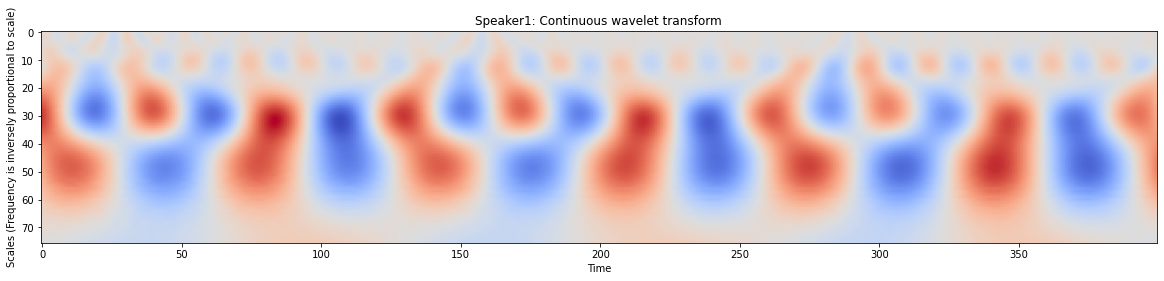

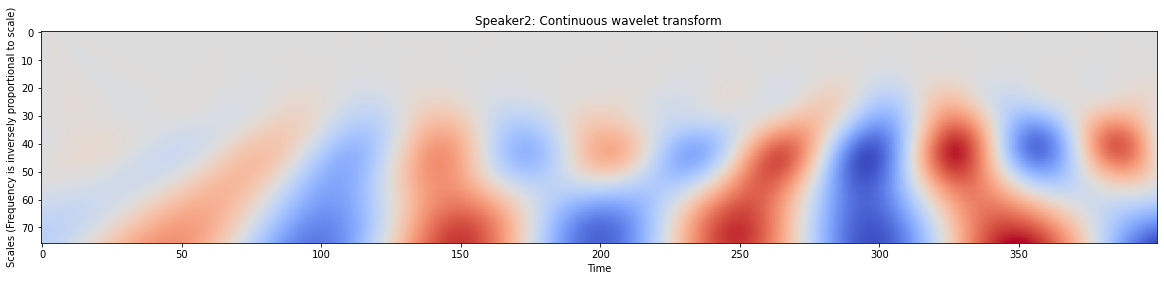

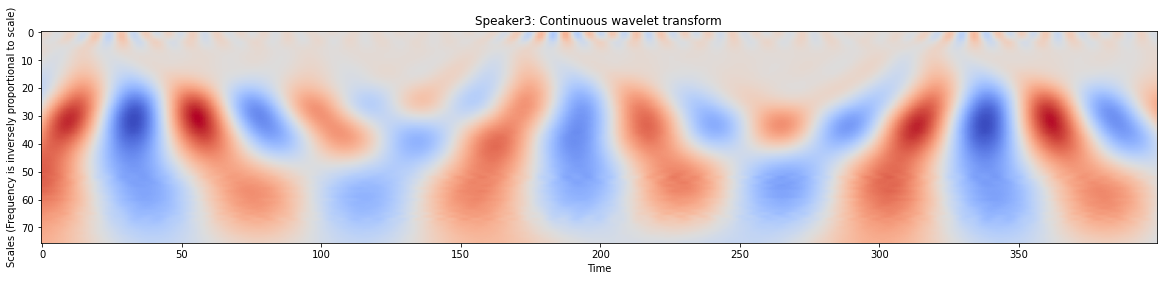

In [ ]:
# Load training features npz file
data = np.load(os.getcwd()+"/training_features.npz")
WaveletFeatTrain = data['a']
WaveletYTrain = data['b']
for i in range(3) :
    ind, = np.where(WaveletYTrain == i)
    sample = WaveletFeatTrain[ind[0]]
    sample = sample.astype(np.float)
    print("Sample shape ", sample.shape)

    # Plot features
    fig = plt.figure(figsize=(20,40))
    plt.imshow(sample, cmap='coolwarm')
    plt.xlabel("Time")
    plt.ylabel("Scales (Frequency is inversely proportional to scale)")
    plt.title("Speaker"+str(i+1)+": Continuous wavelet transform")
    fig.show()

# NOTE: In the image below, notice the difference between different speaker wavelet transforms.

In [ ]:

### Compute Testing data features
'''
WaveletFeatTest = [] # Store wavelet features. We have each sample into frames of length 400
WaveletYTest = [] # Store class labels corresponding to wavelet features from an audio sample
uniq_id = []

for i in tqdm(range(len(audio_test))) :

    curr_sample = audio_test[i]
    seq, _ = librosa.load(curr_sample) 
    curr_target = y_test[i]
    F = compute_wavelet_features(seq)

    # Generate target labels corresponding to the frames of each sample
    WaveletYTest += [curr_target] * len(F)
    uniq_id += [i] * len(F)

    if i == 0 :
        WaveletFeatTest = F
    else :
        WaveletFeatTest = np.concatenate((WaveletFeatTest, F), axis=0) 

WaveletYTest = np.array(WaveletYTest) # Convert to numpy array
uniq_id = np.array(uniq_id)
print("X: ", WaveletFeatTest.shape, "  y: ", WaveletYTest.shape)

WaveletFeatTest = WaveletFeatTest.astype(np.float16)

# Write all features to a .npz file
np.savez_compressed(os.getcwd()+"/testing_features", a=WaveletFeatTest, b=WaveletYTest, c=uniq_id)
'''

'\nWaveletFeatTest = [] # Store wavelet features. We have each sample into frames of length 400\nWaveletYTest = [] # Store class labels corresponding to wavelet features from an audio sample\nuniq_id = []\n\nfor i in tqdm(range(len(audio_test))) :\n\n    curr_sample = audio_test[i]\n    seq, _ = librosa.load(curr_sample) \n    curr_target = y_test[i]\n    F = compute_wavelet_features(seq)\n\n    # Generate target labels corresponding to the frames of each sample\n    WaveletYTest += [curr_target] * len(F)\n    uniq_id += [i] * len(F)\n\n    if i == 0 :\n        WaveletFeatTest = F\n    else :\n        WaveletFeatTest = np.concatenate((WaveletFeatTest, F), axis=0) \n\nWaveletYTest = np.array(WaveletYTest) # Convert to numpy array\nuniq_id = np.array(uniq_id)\nprint("X: ", WaveletFeatTest.shape, "  y: ", WaveletYTest.shape)\n\nWaveletFeatTest = WaveletFeatTest.astype(np.float16)\n\n# Write all features to a .npz file\nnp.savez_compressed(os.getcwd()+"/testing_features", a=WaveletFeatTest

## Step 4: Build a deep learning model

### Our input size is 76 x 400. There are 76 features and 400 timesteps.
### We will follow an architecture similar to wavenet. We will use 1D dilated convolutions. We will also utilize Batch Normalization layers.


In [ ]:
def create_model(row, col) :

    n_filters = 32
    filter_width = 3
    dilation_rates = [2**i for i in range(6)] * 2

    # define an input history series and pass it through a stack of dilated causal convolution blocks
    history_seq = Input(shape=(row, col))
    x = history_seq

    skips = []
    count = 0
    # x = GaussianNoise(0.01)(x)
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        
        # filter
        x = Conv1D(filters=n_filters,
                    kernel_size=filter_width, 
                    padding='causal',
                    dilation_rate=dilation_rate, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(x)
    
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    out = Conv1D(16, 3, padding='same', kernel_initializer= 'random_normal', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = GlobalMaxPool1D()(out)

    out = Dense(3, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(out)
    out = Activation('softmax')(out)

    model = Model(history_seq, out)

    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model

model = create_model(400, 76)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 400, 76)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 400, 32)           7328      
_________________________________________________________________
batch_normalization (BatchNo (None, 400, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 400, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 32)           3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 400, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 400, 32)           0     

## Step 5: Preprocess the data and train the model

### For the neural network, we need the data in format: Num_samples x timesteps x features. But currently the data is in format: Num_samples x features x timesteps. 


In [ ]:
# Load the data
training_data = np.load(os.getcwd()+"/training_features.npz")
X = training_data['a']
y = training_data['b']

X = X.transpose(0,2,1) # Put data in correct format: Num_samples x timesteps x features
y = to_categorical(y) # Convert class labels to categorial vectors
print("X ", X.shape, "y ", y.shape)

# Standardize the data
mean = X.mean()
std = X.std()
X = (X-mean)/ std

print("Mean ", mean, " STD ", std, X.mean(), X.std())

X = X.astype(np.float16)

y = y.astype(np.uint8)

print("Input shapes ", X.shape, y.shape)

# Write the standard deviation and mean in a pickle file
# f = open(os.getcwd()+'/speaker_mean_std.pkl', 'wb')
# pickle.dump([mean, std, y], f)
# f.close()

r,c = X[0].shape

# Split data into training and validation
X1, Xval, y1, yval = train_test_split(X, y, test_size=0.20)#, random_state=int(time.time()))

# Use 5-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

count = 0

# Train the model
# for train, test in kfold.split(X1, np.argmax(y1, axis= -1)):

#     print("K Fold Step  ", count)
#     model.fit(X1[train], y1[train], validation_data= (X1[test], y1[test]), batch_size= 128, epochs= 80, verbose= 2)
#     model.save(os.getcwd()+"/speaker_classifier.h5")

#     count += 1

#     scores = model.evaluate(Xval, yval, verbose=0)
#     print("Metrics : ", scores)


X  (8335, 400, 76) y  (8335, 3)


/Users/adityadutt/Downloads/SpeechTutorial/venv/lib/python3.7/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


Mean  5.4e-07  STD  inf 0.0 0.0
Input shapes  (8335, 400, 76) (8335, 3)


In [ ]:
# Load the model
model = load_model(os.getcwd()+"/speaker_classifier.h5")
f = open(os.getcwd()+'/speaker_mean_std.pkl', 'rb')
mean, std, poss_knnn = pickle.load(f)
f.close()


OSError: SavedModel file does not exist at: /Users/adityadutt/Downloads/SpeechTutorial/speaker_classifier.h5/{saved_model.pbtxt|saved_model.pb}